In [ ]:
%config Completer.use_jedi = False

# Logistic Regression on  Amazon Fine food Review 
The Amazon fine food dataset consists of reviews of fine foods from amazon
All data in one sqlite database. 568,454 food reviews Amazon users left up to October 2012
Data includes:

* Number of reviews :  568,454 reviews
* Number of user : 256,059 users
* Total Number of Producst : 74,258 products
* Time Span of taking Reviews : from Oct 1999 - Oct 2012
* Number of Columns/fields : 10

***Attributes Information :***
1. Id : Row Id
1. ProductId :Unique identifier for the product (74258 unique values)
1. UserId :Unqiue identifier for the user (256059 unique values)
1. ProfileName : Profile name of the user (218418 unique values )
1. HelpfulnessNumerator : Number of users who found the review helpful 
1. HelpfulnessDenominator : Number of users who indicated whether they found the review helpful or not 
1. Score : Rating between 1 and 5
1. Time : Timestamp for the review
1. Summary : Brief summary of the review (295744 unique values)
1. Text : Text of the review (393579 unique values)

> **Objective :** *Given a review ,determine whether a review is postive or negative*

**Q].** *How to determine if a review is postive or negative?*

**Ans.** We can use the Score/rating. A rating of 4 or 5 could be considered as positive review & A rating of 1 or 2 can be consider as negative review . A rating of 3 can be consider as neutral and can be ignored . This is the approximation and proxy way to approach way of determing the polarity(positivity/negativity) of reviews.

# Loadig the data 
The dataset is available in two forms
1. .csv form
2. Sqlite Database

In order to load the database ,I have use the Sqlite Database as it easier to query the data and visualise the data sufficienlty . Here as we only want to get the global sentiment of the recommnedation(Positive/Negative), We will purposefully ignore all the scores equal to 3 ,If the Score is above 3 then the reviews will be "Positive",Otherwise it will "Negative".

# Importing important library

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#mterics 
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_auc_score

import string
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

import os
import pickle 
from tqdm import tqdm


# Readind Data from Sqlite database

In [3]:
#Using the sqlite table to read data
con = sqlite3.connect('database.sqlite')
# Filtering only Positive and Negative Reviews i.e not taking into consideration those reviews with score=3
filtered_data= pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3""",con)
#Given reviews with score>3 a postive rating "1" and reviews with score <3 a negative "0"
#constucting a function
def partition(x):
    if x<3:
        return 0
    return 1
#Changing reviews with score<3 to be negative "0" and score > 3 to be positive "1"
actualscore=filtered_data['Score']
Positve_Negative=actualscore.map(partition)
filtered_data['Score']=Positve_Negative
print("No. of data points in Dataset:",filtered_data.shape)
filtered_data.head(3)


No. of data points in Dataset: (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# Exploratory Data Analysis

### Data Deduplication{The most important part of cleaning data}
It was observes that(as shown in table below) that the reviews data had many deduplicates entries .Hence it is neccessary to remove the deduplication in order to get unbaised results for the Analysis of the data.
Following is the example given below

In [4]:
display= pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3 AND UserId ='AR5J8UI46CURR' ORDER BY ProductId """,con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


**As it can be seen above the same user has multiple reviews of the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)**

**ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on**

**It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.**

**The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product**

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values("ProductId",axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

In [6]:
#Deduplication entries
final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final_data.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
print('The total data remain after cleaning data ',(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)

The total data remain after cleaning data  69.25890143662969


In [8]:
final_data[final_data['HelpfulnessNumerator']>final_data['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
display=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3 AND Id=44737 OR Id=64422
ORDER BY ProductID""",con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


**Observation:** It was seen that in 2 rows given above the value of HelpfullnessNumerator is Greater than HelpfullnessDenominator which is not practically hence such rows are too removed from dataset

In [10]:
final_data=final_data[final_data['HelpfulnessNumerator']<=final_data['HelpfulnessDenominator']]
final_data.shape

(364171, 10)

(364171, 10)


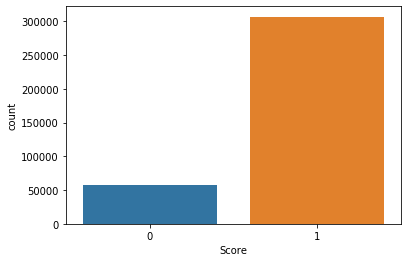

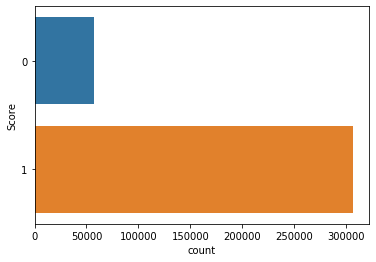

In [11]:
# before starting the next phase of text preprocessing lets see the no. of entries left
print(final_data.shape)
#How many positive and negative reviews are present in our dataset?
final_data['Score'].value_counts()
sns.countplot(final_data['Score'])
plt.show()
sns.countplot(data=final_data,y='Score')

# Text Preprocessing
**Now we have finished deduplication. Now our data requires some preprocessing before we go on futher anlysis and make the prediction model Hence in the preprocessing phase we do the following steps given below**

1. Begin by removing html tags
1. Removing any punctution or limited set of special character:like ,or . or # etc
1. Check the words is made up of english letters and is not alpha-numeric
1. Check to see if the length of the words is greater than 2 (as it was research that there is no adjective in 2 letter)
1. Convert the words to lowercase
1. Remove stopwords
1. Snowball stemming the word(it is observed that Snoball stemming is better that Porter stemming)

***After this we will collect the words and will use to describe positive and negative reviews.***

In [12]:
#finding HTML tags in sentences
import re
i=0
for review in final_data['Text'].values:
    if (len(re.findall('<.*?>',review))):
        print(review)
        break
    i=i+1
print(i)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
6


In [13]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) # creating set of stopwords
print(stop) # it will to show all the stopwords in NLTK
excluding_stop = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
print('****'*15)

stop = [word for word in stop if word not in excluding_stop]
print(' ')
print(stop)
snowstem=nltk.stem.SnowballStemmer('english') # intialising the snowball stemmer
print(' ')
print('****'*15)
print("base_word of tasty:", snowstem.stem('tasty')) # it will tell us the base word or do stemming

# creating a function to clean the word of any html-tags. The function will remove the html tag and evrything between them with "1" space 
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
# creating a function to clean the punctuation or special characters .The function will create the punctuation with empty string
def cleanpunc(sentence):
    cleaned= re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned= re.sub(r'[.|,|)|(|\|/]',r'',cleaned)
    return cleaned
 

{'mightn', 'had', 'further', 'off', 'can', "won't", "you've", "wasn't", 'from', 'ours', 'shouldn', 'weren', 'or', "doesn't", 'herself', 'having', 'been', 'more', "mustn't", "you'll", 'is', 'than', 'are', 'doing', 're', 'an', 'over', 'both', 'not', 'yourself', 'hadn', 'again', 'up', 'those', 'them', 'until', 'its', 'whom', 'same', 'only', 'doesn', 'his', 'where', 'which', "you'd", 'once', 'being', 'her', 'other', 'now', 'theirs', 'for', 'some', "mightn't", 'no', 'your', 'before', "needn't", 'didn', 'down', 'needn', 'who', 'does', "aren't", "hadn't", "haven't", 'about', 'out', 'their', 'how', 'we', 'each', 'too', 'aren', 'has', 't', 'wouldn', 'of', 'through', 'should', 'a', 'against', 'that', 'why', 'was', "it's", 'between', 'nor', 'hasn', 'ain', 'wasn', 'haven', 'isn', 'what', 'our', 'do', 'me', 'you', "isn't", 'myself', 'yours', "wouldn't", 'i', 'have', 'during', 'ourselves', 'him', 'to', 'd', "didn't", "shan't", 'they', 'but', 'my', 'will', "you're", 'he', 'such', "she's", 'below', 'a

In [14]:
# printing some random reviews
sent_0 = final_data['Text'].values[6]
print(sent_0)
print("="*50)

sent_1000 = final_data['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final_data['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final_data['Text'].values[4900]
print(sent_4900)
print("="*50)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than s

In [15]:
import re    #Tutorial about Python regular expressions: https://pymotw.com/2/re/
# remove urls from text python : *https://stackoverflow.com/a/40823105/4084039*
sent_0=re.sub(r'https\S+','',sent_0)
sent_1000=re.sub(r'https\S+','',sent_1000)
sent_1500=re.sub(r'https\S+','',sent_1500)
sent_4900=re.sub(r'http\S+', '', sent_4900)

print(sent_0)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [16]:
pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install lxml

In [17]:
from bs4 import BeautifulSoup
soup=BeautifulSoup(sent_0,'lxml')
text=soup.get_text()
print(text)
print("="*50)

soup=BeautifulSoup(sent_1000,'lxml')
text=soup.get_text()
print(text)
print("="*50)

soup=BeautifulSoup(sent_1500,'lxml')
text=soup.get_text()
print(text)
print("="*50)

soup=BeautifulSoup(sent_4900,'lxml')
text=soup.get_text()
print(text)
print("="*50)


I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.First, this book taught him the months of the year.Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although

In [18]:
import os
import re
def decontracted(phrase):
    phrase=re.sub(r"won't",'will not',phrase)
    phrase=re.sub(r"can\'t",'can not',phrase)
    phrase=re.sub(r"n\'t",'not',phrase)
    phrase=re.sub(r"\'re",'are',phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
#rremove words with no. python  # https://stackoverflow.com/a/18082370/4084039
sent_0=re.sub("\S\d\S","",sent_0).strip()
print(sent_0)
print("="*50)

#remove specail charachter # https://stackoverflow.com/a/5843547/4084039
sent_1500=re.sub('[^A-Za-z0-9]+',' ',sent_1500)
print(sent_1500)


I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today s Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Unt

In [20]:
#Combining all the statement above
from tqdm import tqdm
preprocessed_review=[]
for sentence in tqdm(final_data['Text'].values):
    sentence=re.sub(r"http\S+", "",sentence)
    sentence=BeautifulSoup(sentence,'lxml').get_text()
    sentence=decontracted(sentence)
    sentence=re.sub("\S*\d\S*","",sentence).strip()
    sentence=re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence=' '.join(e.lower() for e in sentence.split() if e.lower() not in stop)
    preprocessed_review.append(sentence.strip())
    

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [06:18<00:00, 963.28it/s]


In [21]:
from tqdm import tqdm
preprocessed_summary=[]
for sentence in tqdm(final_data['Summary'].values):
    sentence=re.sub(r"http\S+", "",sentence)
    sentence=BeautifulSoup(sentence,'lxml').get_text()
    sentence=decontracted(sentence)
    sentence=re.sub("\S*\d\S*","",sentence).strip()
    sentence=re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence=' '.join(e.lower() for e in sentence.split() if e.lower() not in stop)
    preprocessed_summary.append(sentence.strip())
    

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [03:59<00:00, 1523.17it/s]


In [22]:
pip install bs4

In [23]:
#SENTENCES Containing HTML tags
import re
i=0;
for sentence in final_data['Text'].values:
    if (len(re.findall('<.*?>',sentence))):
        break;
    print("="*50)
    print(i,")>>",sentence)
    i=i+1
print("="*50)

0 )>> this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
1 )>> I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
2 )>> This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem.
3 )>> This is a great little book to read aloud- it has a nice rhythm as well as good repetition that little ones like, in the lines about "chicken soup with rice



print("Total no. of sentences containing html tags",i)
#Set of stopwords
#stop_words=set(stopwords.word('english'))

# we are removing the words from the stop words list: 'no', 'nor', 'not' for semantic meanig in bigrams and trigram
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn',  'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',  'weren', \
            'won', "won't", 'wouldn'])
stemming=nltk.stem.SnowballStemmer('english')

#creating funtion to remove html tags from words 
#https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
#1st:Using regrex
def cleanhtml(sentencs):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentencs)
    return cleantext
#OR
#2ndUsing Beautiful
from bs4 import BeautifulSoup
cleantext=BeautifulSoup(sentence,"lxml").text

##function to clean the word of any punctuation or special characters
def cleanpunc(sentence):
    #clean =re.sub('[^A-Za-z0-9]+', '', sentence)
    cleanp=re.sub(r'[?|!|\'|"|#]',r'',sentence)
    clean_punc=re.sub(r'[.|,|)|(|\|/]',r' ',cleanp)
    return clean_punc
print('stop words are :',stopwords)
print("*********************")
print('base word for tasty is :',stemming.stem('tasty'))


# 
#the code will take time to run 
if not os.path.isfile('finalsqlite'):
    final_string=[]
    all_postive_words=[]
    all_negative_words=[]
    for i , sentence in enumerate(tqdm(final_data['Text'].values)):
        filter_sentence=[]
        sent=cleanhtml(sentence)
        for words in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for clean_words in cleanpunc(words).split():
                if ((clean_words.isalpha())&(len(clean_words)>2)):
                    if (clean_words.lower() not in stopwords):
                        s = (stemming.stem(clean_words.lower())).encode(encoding='UTF-8')
                        filter_sentence.append(s)
                        if (final_data['Score'].values)[i]==1:
                            #list of all words used to describe positive reviews
                            all_postive_words.append(s)  
                            
                        if (final_data['Score'].values)[i]==0:
                            #list of all words used to describe negative reviews
                            all_negative_words.append(s)  
                    else:
                        continue
                else:
                    continue
        str1=b" ".join(filter_sentence)#final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)
        i+=1
     

In [24]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final_data['Cleaned Text']=preprocessed_review
final_data['Cleaned_Summary']=preprocessed_summary

#print(final_data[['Text','Clean_text']])
#final_data['Cleaned Text']=final_data['Cleaned Text'].str.decode('UTF-8')

In [25]:
# converting time in unit=sec
final_data['Time']=pd.to_datetime(final_data['Time'],unit='s')
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned Text,Cleaned_Summary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,2007-11-11,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,2007-10-04,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,chicken soup rice months
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,2004-02-06,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...,good swingy rhythm reading aloud
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,2002-04-10,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...,great way learn months


# Sorting dataset based on 'Time' feature

In [26]:
final_data=final_data.sort_values('Time',axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned Text,Cleaned_Summary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...,whole series great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...,entertainingl funny
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...,modern day fairy tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...,fantastic


In [27]:
#Store the final table into an SQLITE table for future
connection=sqlite3.connect('final12.sqlite')
c=connection.cursor
connection.text_factory=str
final_data.to_sql('Reviews',connection,schema=None,if_exists='replace',index=True,index_label=True,chunksize=None,dtype=None)
connection.close()

# Assignment 5: Apply Logistic Regression
1. Apply Logistic Regression on these feature sets
    * Review text, preprocessed one converted into vectors using (BOW)
    * Review text, preprocessed one converted into vectors using (TFIDF)
    * Review text, preprocessed one converted into vectors using (AVG W2v)
    * Review text, preprocessed one converted into vectors using (TFIDF W2v)

1. Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)
    * Finding the best hyper parameter which will give the maximum AUC value
                OR
    * Finding the best hyper paramter using k-fold cross validation or simple cross validation data
                OR
    * Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning

1. Pertubation Test
    * Get the weights W after fit your model with the data X.
    * Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse matrix, X.data+=e)
    * Fit the model again on data X' and get the weights W'
    * Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-6
    * Now find the % change between W and W' (| (W-W') / (W) |)*100)
    * Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector
    * Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5
    * Printing the feature names whose % change is more than a threshold x(in our example it's 2.5)

1. Sparsity
    * Calculate sparsity on weight vector obtained after using L1 regularization
    
1. Feature importance
    * Get top 10 important features for both positive and negative classes separately.

1. Feature engineering
    * To increase the performance of your model, we can also experiment with with feature engineering like :
        * Taking length of reviews as another feature.
        * Considering some features from review summary as well.

1. Representation of results
    * ploting the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    * Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    * Along with plotting ROC curve, you need to print the confusion matrix with predicted and original labels of test data points. Please visualize your confusion matrices using seaborn heatmaps.

1. Conclusion
    * summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library link


1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it.
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.


In [28]:
# taking equal no. of negative and positive data points
data_pos=final_data[final_data['Score']==1].sample(n=60000)
data_neg=final_data[final_data['Score']==0].sample(n=57000)
final=pd.concat([data_pos,data_neg])
final.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned Text,Cleaned_Summary
347035,375393,B000V4ZY6U,A1QH882X58XK9T,Patrick Purdy,1,2,0,2009-07-09,not Plain salt !!!,They should mention somewhere in the descripti...,mention somewhere description flavored salt ar...,not plain salt
6034,6533,B00008O36H,A2M9PWAYQIYD0B,Ross,0,0,0,2009-10-23,unless you want to pick dog poop off the floor...,We have two dogs and after a few weeks of swit...,two dogs weeks switching beneful healthy weigh...,unless want pick dog poop floor donot recommend
345178,373411,B001BM62T4,A7Y9MP7H8LYUE,"K. E. Steelman ""mommarock""",0,0,0,2009-07-16,This drink doesn't fit in either category.,I am both an avid tea drinker and sort of a ma...,avid tea drinker sort manic coffee person defi...,drink doesnot fit either category
378900,409688,B007NPQRW0,AXLXE8WL6JFY6,Mswilk,0,1,0,2012-09-27,These are ok,"I wasn't 100% satisfied with these suckers, th...",wasnot satisfied suckers really flavor ended t...,ok
222758,241554,B000PJF7BS,A33LUVJZ98CMNK,"Elle ""jadesong86""",1,2,0,2009-11-12,"Overly sweet, and flavor doesn't last",The point of this gum is to take one of the so...,point gum take one sours one sweets mix togeth...,overly sweet flavor doesnot last


# Apply Logistic Regression on BOW

In [29]:
y= final['Score']
X = final['Cleaned Text']
print("Shape of X",X.shape)
print("Shape of y",y.shape)

Shape of X (117000,)
Shape of y (117000,)


In [30]:
from sklearn.model_selection import train_test_split
X_tr ,X_test,y_tr,y_test = train_test_split(X,y,test_size=.30,random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_tr, y_tr, test_size=.30, random_state=0)
print('Shape of X_train is :',X_train.shape)
print('Shape of y_train is :',y_train.shape)
print("****"*6)
print('Shape of X_Cv is :',X_cv.shape)
print('Shape of y_cv is :',y_cv.shape)
print("****"*6)
print('Shape of X_test is :',X_test.shape)
print('Shape of y_test is :',y_test.shape)
print("****"*6)
print('Shape of X_tr is :',X_tr.shape)
print('Shape of y_tr is :',y_tr.shape)

Shape of X_train is : (57330,)
Shape of y_train is : (57330,)
************************
Shape of X_Cv is : (24570,)
Shape of y_cv is : (24570,)
************************
Shape of X_test is : (35100,)
Shape of y_test is : (35100,)
************************
Shape of X_tr is : (81900,)
Shape of y_tr is : (81900,)


## 1. Apply Logistic Regression with L2 regularization on BOW 

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
# *Converting text into vectors using BOW
bow_count_vect=CountVectorizer()
bow_count_vect.fit(X_train)
# Using the fited CountVectorizer to convert text to vectors
Xtrain_bow=bow_count_vect.transform(X_train)
Xcv_bow=bow_count_vect.transform(X_cv)
Xtest_bow=bow_count_vect.transform(X_test)
print("After vectorizations")
print(Xtrain_bow.shape, y_train.shape)
print(Xcv_bow.shape, y_cv.shape)
print(Xtest_bow.shape, y_test.shape)
#print(X_tr_bow.shape, y_tr.shape)

After vectorizations
(57330, 46695) (57330,)
(24570, 46695) (24570,)
(35100, 46695) (35100,)


YOU SHOULD NOT DO LIKE THIS
1. THE VOCABULARY SHOULD BUILT ONLY WITH THE WORDS OF TRAIN DATA
    * vectorizer = CountVectorizer()
    * x_train_bow = vectorizer.fit_transform(X_train)
    * x_cv_bow = vectorizer.fit_transform(X_cv)
    * x_test_bow = vectorizer.fit_transform(X_test)
    
2. DATA LEAKAGE PROBLEM: IF WE DO LIKE THIS WE ARE LOOKING AT THE TEST DATA BEFORE MODELING
    * vectorizer = CountVectorizer()
    * X_bow = vectorizer.fit_transfomr(X)
    * X_train, X_test, y_train, y_test = train_test_split(X_bow, Y, test_size=0.33)
    
3. YOU SHOULD PASS THE PROBABILITY SCORES NOT THE PREDICTED VALUES
    * y_pred = neigh.predict(X)
    * roc_auc_score(y_ture,y_pred)

In [32]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler(with_mean=False)
scaler.fit(Xtrain_bow)
X_tr_bow=scaler.transform(Xtrain_bow)
X_test_bow=scaler.transform(Xtest_bow)
X_cv_bow=scaler.transform(Xcv_bow)
print("After standardising")
print(X_tr_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
#print(X_tr_bow.shape, y_tr.shape)

After standardising
(57330, 46695) (57330,)
(24570, 46695) (24570,)
(35100, 46695) (35100,)


1e-05 --------> 0.9352553259446112
0.0001 --------> 0.9374820200525456
0.001 --------> 0.9285772127091058
0.01 --------> 0.9093103898082111
0.1 --------> 0.8820152988878794
1 --------> 0.8610216684244261
2.1 --------> 0.8575608399388124
10 --------> 0.8541230007248167
100 --------> 0.8473005340903385
1000 --------> 0.846381460470138
10000 --------> 0.8454457324734981
100000 --------> 0.8436618478700282
Optimal C  is : 0.0001


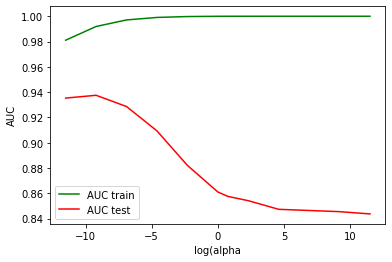

In [33]:
import math
from sklearn.model_selection import cross_val_score
C =[0.00001,0.0001,0.001,0.01,0.1,1,2.1,10,100,1000,10000,100000]#C=1/lambda
auc_train=[]
auc_cv=[]
for c in C:
    model_logreg=LogisticRegression(penalty='l2',C=c)
    model_logreg.fit(X_tr_bow,y_train)
    
    y_pred_train=model_logreg.predict_proba(X_tr_bow)[:,1]
    auc_train.append(roc_auc_score(y_train,y_pred_train))
    
    y_pred_cv=model_logreg.predict_proba(X_cv_bow)[:,1]
    auc_cv.append(roc_auc_score(y_cv,y_pred_cv))
    
    auc_score_cv =roc_auc_score(y_cv,y_pred_cv)
    print(c,"-------->",auc_score_cv )
    
optimal_C=C[auc_cv.index(max(auc_cv))]
c=[math.log(x) for x in C]
print('Optimal C  is :',optimal_C)
fig =plt.figure()
plt.plot(c,auc_train,color='green',label='AUC train')
plt.plot(c,auc_cv,color='red',label='AUC test')
plt.legend(loc='best')
plt.xlabel('log(alpha')
plt.ylabel('AUC')
plt.show()

                           Or

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [04:01<00:00, 20.11s/it]



The optimal number of alpha is  0.0001


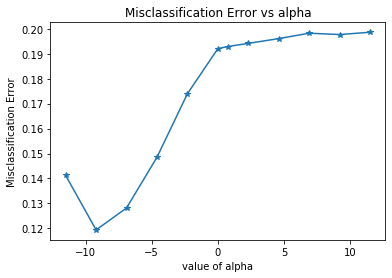

In [34]:
#Finding optimal_alpha by using 10-fold_cv
from sklearn.model_selection import cross_val_score
alpha_C=[0.00001,0.0001,0.001,0.01,0.1,1,2.1,10,100,1000,10000,100000]
cv_scores=[]
#perfrom 10-fold cv
for i in tqdm(alpha_C):
    model_logreg=LogisticRegression(penalty='l2',C=i)
    scores=cross_val_score(model_logreg,X_tr_bow,y_train,cv=10)
    cv_scores.append(scores.mean())
#Changing to misclassification error
MSE=[1 - x for x in cv_scores]

#determing best alpha
optimal_C=alpha_C[MSE.index(min(MSE))]
aplha_C=[math.log(x) for x in alpha_C]
print('\nThe optimal number of alpha is ',optimal_C)
#Plot the misclassfication error vs alpha
plt.plot(aplha_C,MSE,marker='*')
plt.title("Misclassification Error vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [35]:
optimal_C

0.0001

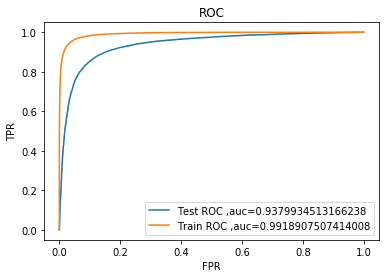

In [36]:
#ROC for labmda=
lr=LogisticRegression(penalty='l2',C=optimal_C)
lr.fit(X_tr_bow,y_train)
predi=lr.predict_proba(X_test_bow)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=lr.predict_proba(X_tr_bow)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

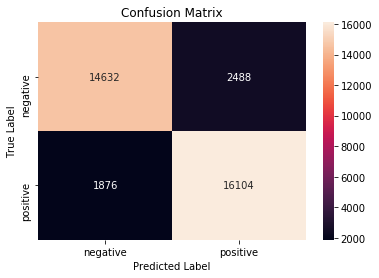

In [37]:
#Confusion matrix using heat map for test data
from sklearn.metrics import  confusion_matrix
logreg=LogisticRegression(penalty='l2',C=optimal_C)
logreg.fit(X_tr_bow,y_train)
pred=logreg.predict(X_test_bow)
import seaborn as sns
conf_mat=confusion_matrix(y_test,pred)
class_label = ["negative", "positive"]
df=pd.DataFrame(conf_mat,columns=class_label,index=class_label)
sns.heatmap(df,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#  Performing pertubation test (multicollinearity check) on BOW

In [ ]:
Weights_before=logreg.coef_

X_e=X_tr_bow
print('Shape of X_e before adding noise ',X_e.shape)
X_e.data=X_e.data+np.random.normal(loc=0,scale=0.0001,size=X_e.data.shape)
print('Shape of X_e.data',X_e.data.shape)
print('Shape of X_e after adding noise',X_e.shape)

In [ ]:
#Training Logistic regression With X_e
lr_e=LogisticRegression(penalty='l2',C=optimal_C)
lr_e.fit(X_e,y_train)
W_after=lr_e.coef_

In [ ]:
#list(Weights_before[0])

In [ ]:
#to eliminate divisible by zero error we will add 10^-6 to W_before and W_after
Weights_before+=10**-6
W_after+=10**-6

per_vectors=[]

print(len(Weights_before[0]))

for i in range(len(Weights_before[0])):
    val=W_after[0][i]-Weights_before[0][i]
    val/=Weights_before[0][i]
    per_vectors.append(val)
    
Original_per_vect=np.absolute(per_vectors)
per_vectors=sorted(np.absolute(per_vectors))[::-1]
#percentage change iin vectors 
per_vectors[:10]
    

In [ ]:
type(per_vectors)

In [ ]:
#calculating percentile from 0 to 100:
for i in range(11): #https://www.geeksforgeeks.org/numpy-percentile-in-python/ 
    print(str(i*10)+'th percentile = '+str(np.percentile(per_vectors,i*10)))

In [ ]:
#there is sudden rise in percentile from 90 to 100
#calculating percentile from 9 to 100:

for i in range(90,101): #https://www.geeksforgeeks.org/numpy-percentile-in-python/ 
    print(str(i)+'th percentile = '+str(np.percentile(per_vectors,i)))

In [ ]:
#there is sudden rise in percentile from 99 to 100
#calculating percentile from 99 to 100:

for i in range(1,11): #https://www.geeksforgeeks.org/numpy-percentile-in-python/ 
    print(str(99+(10**-1)*i)+'th percentile = '+str(np.percentile(per_vectors,99+(10**-1)*i)))

In [ ]:
#finding features from 99.9th percentile to 100th percentile
print('features from 99.9th percentile to 100th percentile')
original_per_vect=Original_per_vect.tolist()
all_features=bow_count_vect.get_feature_names()
#for i in range(1,11): #https://www.geeksforgeeks.org/numpy-percentile-in-python/ 
    #index=original_per_vect.index(np.percentile(per_vectors,99.9+(10**-2)*i))
    #print(all_features[index])
#indx=original_per_vect.index(index)
#print(all_features[indx])

# Feature Importance on BOW,

In [ ]:
weight=logreg.coef_
#x = np.array([3, 1, 2])
#np.argsort(x)
#array([1, 2, 0])
pos_index=np.argsort(weight)[:,::-1]
neg_index=np.argsort(weight)


In [ ]:
### Top 10 important features of positive class from
print('Top 10 important features of positive class ')
for i in list(pos_index[0][:10]):
    print(all_features[i])

In [ ]:
### Top 10 important features of positive class from
print('Top 10 important features of neagtive class ')
for i in list(neg_index[0][:10]):
    print(all_features[i])

# 1. Apply Logistic Regression with L2 regularization on Tfidf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Conveting text into vectors using Tf_idf

tf_idf_vect=TfidfVectorizer(ngram_range=(1,2))  #taking both unigram and bigram
tf_idf_vect.fit(X_train)
# Using the transrom fucntion TfidfVectorizer  convert text to vectors
Xtrain_tf_idf=tf_idf_vect.transform(X_train)
Xcv_tf_idf   =tf_idf_vect.transform(X_cv)
Xtest_tf_idf =tf_idf_vect.transform(X_test)
print("After vectorizations")
print(Xtrain_tf_idf.shape, y_train.shape)
print(Xcv_tf_idf.shape, y_cv.shape)
print(Xtest_tf_idf.shape, y_test.shape)

In [ ]:
import math
from sklearn.model_selection import  cross_val_score
C =[0.00001,0.0001,0.001,0.01,0.1,1,2.1,10,100,1000,10000,100000]#C=1/lambda
auc_train=[]
auc_cv=[]
for c in C:
    model_logreg=LogisticRegression(penalty='l2',C=c)
    model_logreg.fit(Xtrain_tf_idf,y_train)
    
    y_pred_train=model_logreg.predict_proba(Xtrain_tf_idf)[:,1]  #[:,1] its used for saving ony positve class
    auc_train.append(roc_auc_score(y_train,y_pred_train))
    
    y_pred_cv=model_logreg.predict_proba(Xcv_tf_idf)[:,1]
    auc_cv.append(roc_auc_score(y_cv,y_pred_cv))
    
    auc_score_cv=roc_auc_score(y_cv,y_pred_cv)
    print(c,"-------->",auc_score_cv )

optimal_c=C[auc_cv.index(max(auc_cv))]
c=[math.log(x) for x in C]
print("Optimal c:",optimal_c)
fig=plt.figure()
plt.plot(c,auc_train,color='green',label='Auc_Train')
plt.plot(c,auc_cv,color='red',label='Auc_Test')
plt.legend(loc='best')
plt.xlabel('log(alpha')
plt.ylabel('AUC')
plt.show()


   Another way of finding optimal_C

In [ ]:
#Finding optimal_alpha by using 10-fold_cv
from sklearn.model_selection import cross_val_score
alpha_C=[0.00001,0.0001,0.001,0.01,0.1,1,2.1,10,100,1000,10000,100000]
cv_score_tfidf=[]
#perform 10-foldcv
for i in tqdm(alpha_C):
    model_logreg_tfidf=LogisticRegression(penalty='l2',C=i)
    score_tfidf=cross_val_score(model_logreg_tfidf,Xtrain_tf_idf,y_train,cv=10)
    cv_score_tfidf.append(score_tfidf.mean())
    
#Changing to misclassification error
MSE=[1-x for x in cv_score_tfidf]

#determine  best alpha
optimal_C_tfidf=alpha_C[MSE.index(min(MSE))]
print("Optimal c:",optimal_C_tfidf)
alpha_C=[math.log(x) for x in alpha_C]
#Plot the misclassfication error vs alpha
plt.plot(alpha_C,MSE,marker='*')
plt.title("Misclassification Error vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [ ]:
# Roc for allpha =1000
model=LogisticRegression(penalty='l2',C=optimal_C_tfidf)
model.fit(Xtrain_tf_idf,y_train)

y_test_pred=model.predict_proba(Xtest_tf_idf)[:,1]
fpr1,tpr1,thresholds1=metrics.roc_curve(y_test,y_test_pred)

y_train_pred=model.predict_proba(Xtrain_tf_idf)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,y_train_pred)

fig=plt.figure()
ax=plt.subplot(111)
ax.plot(fpr1,tpr1,label="Test Roc,auc="+str(roc_auc_score(y_test,y_test_pred)))
ax.plot(fpr2,tpr2,label="Train Roc,Auc="+str(roc_auc_score(y_train,y_train_pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()


In [ ]:
#Confusion matrix using heat map for test data
from sklearn.metrics import  confusion_matrix
lr=LogisticRegression(penalty='l2',C=optimal_C_tfidf)
lr.fit(Xtrain_tf_idf,y_train)
pred=lr.predict(Xtest_tf_idf)

import seaborn as sns
con_mat=confusion_matrix(y_test,pred)
class_label=['negative','positive']
df=pd.DataFrame(con_mat,index=class_label,columns=class_label)
sns.heatmap(df,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Feature Importance on TFIDF

In [ ]:
all_features = tf_idf_vect.get_feature_names()
weight=lr.coef_
#x = np.array([3, 1, 2])
#np.argsort(x)
#output >> array([1, 2, 0])
pos_index=np.argsort(weight)[:,::-1]
neg_index=np.argsort(weight)

In [ ]:
### Top 10 important features of positive class from
print('Top 10 important features of positive class ')
for i in list(pos_index[0][:10]):
    print(all_features[i])

In [ ]:
#Top 10 important features of negative class -=
print("top 10 negative features:")
for i in list(neg_index[0][0:10]):
    print(all_features[i])

# Word2Vec

In [ ]:
i=0
list_of_Xtr=[]
for sent in X_train:
    list_of_Xtr.append(sent.split())
print("len of list_of_Xtr :",len(list_of_Xtr))

i=0
list_of_Xtest=[]
for sent in X_test:
    list_of_Xtest.append(sent.split())
print("len of list_of_Xtest :",len(list_of_Xtest))

i=0
list_of_Xcv=[]
for sent in X_cv:
    list_of_Xcv.append(sent.split())
print("len of list_of_Xcv :",len(list_of_Xcv))


In [ ]:
# To Train the word2vec model using train data
w2v_model=Word2Vec(list_of_Xtr,min_count=2,size=50,workers=4)

#min_count :means if a word doesnt occur atleast 5 times don't create word2vec
# vector_size :is the number of dimensions (N) of the N-dimensional space that gensim Word2Vec maps the words onto.
#workers : the last of the major parameters (full list here) is for training parallelization, to speed up training:

In [ ]:
w2v_words=list(w2v_model.wv.vocab)
print("number of words that occured minimum 2 times ",len(w2v_words))
print('='*50)
print("sample words ", w2v_words[0:50])

In [ ]:
print(w2v_model.wv['great'])
print('='*50)
print(len(w2v_model.wv['great']))

In [ ]:
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

# Converting text into vectors using Avg W2V

In [ ]:
#Avg W2Vec on train data 
#computing average word2vec for each reviews
sent_vectors_train=[]
for sent in tqdm(list_of_Xtr):
    sent_vec=np.zeros(50)
    count_words=0
    for word in sent:
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec+=vec
            count_words+=1
    if count_words!=0:
        sent_vec/=count_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))


In [ ]:
#Avg W2Vec on test data 
#computing average word2vec for each reviews
sent_vectors_test=[]
for sent in tqdm(list_of_Xtest):
    sent_vec=np.zeros(50)
    count_words=0
    for word in sent:
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec+=vec
            count_words+=1
    if count_words!=0:
        sent_vec/=count_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

In [ ]:
#Avg W2Vec on cv data 
#computing average word2vec for each reviews
sent_vectors_cv=[]
for sent in tqdm(list_of_Xcv):
    sent_vec=np.zeros(50)
    count_words=0
    for word in sent:
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec+=vec
            count_words+=1
    if count_words!=0:
        sent_vec/=count_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

In [ ]:
x_train_avg=sent_vectors_train
x_test_avg=sent_vectors_test
x_cv_avg=sent_vectors_cv

scaler =StandardScaler(with_mean=False)
scaler.fit(x_train_avg)

x_train_avg=scaler.transform(x_train_avg)
x_test_avg=scaler.transform(x_test_avg)
x_cv_avg=scaler.transform(x_cv_avg)

print(len(x_train_avg))
print(len(x_train_avg[0]))

print(len(x_test_avg))
print(len(x_test_avg[0]))

print(len(x_cv_avg))
print(len(x_cv_avg[0]))

In [ ]:
#Finding optimal_alpha by using 10-fold_cv
from sklearn.model_selection import cross_val_score
alpha_C=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
cv_score_avg_w2v=[]
#perform 10-foldcv
for i in tqdm(alpha_C):
    lr=LogisticRegression(penalty='l2',C=i)
    score_avg_W2v=cross_val_score(lr,x_train_avg,y_train,cv=10)
    cv_score_avg_w2v.append(score_avg_W2v.mean())
    
#Changing to misclassification error
MSE=[1-x for x in cv_score_avg_w2v]

#determine  best alpha
optimal_C_avg_W2v=alpha_C[MSE.index(min(MSE))]
print("Optimal c:",optimal_C_avg_W2v)
alpha_C=[math.log(x) for x in alpha_C]
#Plot the misclassfication error vs alpha
plt.plot(alpha_C,MSE,marker='*')
plt.title("Misclassification Error vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [ ]:
# Roc 
lr =LogisticRegression(penalty='l2',C=optimal_C_avg_W2v)
lr.fit(x_train_avg,y_train)

y_test_pred=lr.predict_proba(x_test_avg)[:,1]
fpr1,tpr1,thresholds1=metrics.roc_curve(y_test,y_test_pred)

y_train_pred=lr.predict_proba(x_train_avg)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,y_train_pred)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,y_test_pred)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,y_train_pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

In [ ]:
#Confusion matrix using heatmap for test data
from sklearn.metrics import confusion_matrix
lr=LogisticRegression(penalty='l2',C=optimal_C_avg_W2v)
lr.fit(x_train_avg,y_train)
y_predict=lr.predict(x_test_avg)

con_matrix=confusion_matrix(y_test,y_predict)
class_label=["negative", "positive"]
df=pd.DataFrame(con_matrix,index=class_label,columns=class_label)
sns.heatmap(df,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Applying Logistic Regression with L2 regularization on TFIDF W2V,

In [ ]:
from sklearn.model_selection import train_test_split
X_tr ,X_test,y_tr,y_test = train_test_split(X,y,test_size=.30,random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_tr, y_tr, test_size=.30, random_state=0)
print('Shape of X_train is :',X_train.shape)
print('Shape of y_train is :',y_train.shape)
print("****"*6)
print('Shape of X_Cv is :',X_cv.shape)
print('Shape of y_cv is :',y_cv.shape)
print("****"*6)
print('Shape of X_test is :',X_test.shape)
print('Shape of y_test is :',y_test.shape)
print("****"*6)
print('Shape of X_tr is :',X_tr.shape)
print('Shape of y_tr is :',y_tr.shape)

In [ ]:
i=0
list_of_Xtr=[]
for sent in X_train:
    list_of_Xtr.append(sent.split())
print("len of list_of_Xtr :",len(list_of_Xtr))

i=0
list_of_Xtest=[]
for sent in X_test:
    list_of_Xtest.append(sent.split())
print("len of list_of_Xtest :",len(list_of_Xtest))

i=0
list_of_Xcv=[]
for sent in X_cv:
    list_of_Xcv.append(sent.split())
print("len of list_of_Xcv :",len(list_of_Xcv))


In [ ]:
# To Train the word2vec model
w2v_model=gensim.models.Word2Vec(list_of_Xtr,min_count=5,size=50,workers=4)
#min_count :means if a word doesnt occur atleast 5 times don't create word2vec
# vector_size :is the number of dimensions (N) of the N-dimensional space that gensim Word2Vec maps the words onto.
#workers : the last of the major parameters (full list here) is for training parallelization, to speed up training:
w2vwords=list(w2v_model.wv.vocab)

In [ ]:
tf_idf_model=TfidfVectorizer()
tf_idf_model.fit_transform(X_train)
#creating a dictinory with a word  as a key and the idf as value
dictionary=dict(zip(tf_idf_model.get_feature_names(),list(tf_idf_model.idf_)))

dictionary

In [ ]:
tfidf_feat=tf_idf_model.get_feature_names()

tf_idf_sent_vect_train=[]
row=0
for sent in tqdm(list_of_Xtr):
    sent_vec=np.zeros(50)
    weight_sum=0
    for word in sent:
        if word in w2vwords and word in tfidf_feat:
            vec=w2v_model.wv[word]
            #tf_idf=final_tf_idf[row,tfidf_feat.index(word)]
            # to reduce the computation we are computing 
            #dictionary[word]:idf value of the word in whole corpus 
            #dictionary['aberfoyl get'] output:>>11.263449588064944
            #sent.count(word):tfvalues of word in this reviews
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))
            #sent.count(word) gives us the count of word in sentence and
            #then we're dividing this term by total number of words in sent that gives us tf value.
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
    if weight_sum!=0:
        sent_vec/=weight_sum
    tf_idf_sent_vect_train.append(sent_vec)
    row+=1
            

In [ ]:
print(len(tf_idf_sent_vect_train))
print(len(tf_idf_sent_vect_train[0]))

In [ ]:
tfidf_feat=tf_idf_model.get_feature_names()

tf_idf_sent_vect_test=[]
row=0
for sent in tqdm(list_of_Xtest):
    sent_vec=np.zeros(50)
    weight_sum=0
    for word in sent:
        if word in w2vwords and word in tfidf_feat:
            vec=w2v_model.wv[word]
            #tf_idf=final_tf_idf[row,tfidf_feat.index(word)]
            # to reduce the computation we are computing 
            #dictionary[word]:idf value of the word in whole corpus 
            #dictionary['aberfoyl get'] output:>>11.263449588064944
            #sent.count(word):tfvalues of word in this reviews
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))
            #sent.count(word) gives us the count of word in sentence and
            #then we're dividing this term by total number of words in sent that gives us tf value.
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
    if weight_sum!=0:
        sent_vec/=weight_sum
    tf_idf_sent_vect_test.append(sent_vec)
    row+=1
            

In [ ]:
print(len(tf_idf_sent_vect_test))
print(len(tf_idf_sent_vect_test[0]))

In [ ]:
tf_idf_sent_vect_cv=[]
row=0
for sent in tqdm(list_of_Xcv):
    sent_vec=np.zeros(50)
    weight_sum=0
    for word in sent:
        if word in w2vwords and word in tfidf_feat:
            vec=w2v_model.wv[word]
            #tf_idf=final_tf_idf[row,tfidf_feat.index(word)]
            # to reduce the computation we are computing 
            #dictionary[word]:idf value of the word in whole corpus 
            #dictionary['aberfoyl get'] output:>>11.263449588064944
            #sent.count(word):tfvalues of word in this reviews
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))
            #sent.count(word) gives us the count of word in sentence and
            #then we're dividing this term by total number of words in sent that gives us tf value.
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
    if weight_sum!=0:
        sent_vec/=weight_sum
    tf_idf_sent_vect_cv.append(sent_vec)
    row+=1

In [ ]:
print(len(tf_idf_sent_vect_cv))
print(len(tf_idf_sent_vect_cv[0]))

In [ ]:
X_train_tf_df_w2vec=tf_idf_sent_vect_train
X_test_tf_df_w2vec=tf_idf_sent_vect_test
X_cv_tf_df_w2vec=tf_idf_sent_vect_cv

C_ = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
auc_train=[]
auc_cv=[]
for c in C_:
    lr=LogisticRegression(penalty='l2',C=c)
    lr.fit(X_train_tf_df_w2vec,y_train)
    
    y_pred_cv=lr.predict_proba(X_cv_tf_df_w2vec)[:,1]
    auc_cv.append(roc_auc_score(y_cv,y_pred_cv))
    
    y_pred_train=lr.predict_proba(X_train_tf_df_w2vec)[:,1]
    auc_train.append(roc_auc_score(y_train,y_pred_train))
    
    auc_score_cv=roc_auc_score(y_cv,y_pred_cv)
    print(c,"-------->",auc_score_cv )

optimal_c_tfidf_w2v=C_[auc_cv.index(max(auc_cv))]
c=[math.log(x) for x in C_]
print("Optimal c:",optimal_c_tfidf_w2v)
fig=plt.figure()
plt.plot(c,auc_train,color='green',label='Auc_Train')
plt.plot(c,auc_cv,color='red',label='Auc_Test')
plt.legend(loc='best')
plt.xlabel('log(alpha')
plt.ylabel('AUC')
plt.show()
    

In [ ]:
#Roc 
lr=LogisticRegression(penalty='l2',C=optimal_c_tfidf_w2v)
lr.fit(X_train_tf_df_w2vec,y_train)
    
y_pred_test=lr.predict_proba(X_test_tf_df_w2vec)[:,1]
fpr1,tpr1,thresholds1=metrics.roc_curve(y_test,y_pred_test)

y_pred_train=lr.predict_proba(X_train_tf_df_w2vec)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,y_pred_train)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,y_pred_test)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,y_pred_train)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

In [ ]:
#Confusion matrix using Heat map for test data
#Confusion matrix using heatmap for test data
from sklearn.metrics import confusion_matrix
lr=LogisticRegression(penalty='l2',C=optimal_c_tfidf_w2v)
lr.fit(X_train_tf_df_w2vec,y_train)
y_predic=lr.predict(X_test_tf_df_w2vec)

from sklearn.metrics import confusion_matrix
import seaborn as sns    
conf_matrix=confusion_matrix(y_test,y_predic)
class_label=['negative','postive']
df=pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer","Regularization", "Feature engineering", "Hyperameter", "AUC"]
x.add_row(["BOW","l2","Not featured",0.0001,0.9398])
x.add_row(["TFIDF","l2","Not featured",10000,0.9688])
x.add_row(["Avg W2v","l2","Not featured",10,0.9184])
x.add_row(["TFIDF Avg W2v","l2","Not featured",1,0.8971])

print(x)

1. First we split whole preprocessed review data to train ,cross validation and test 
2. Then we applied logistic regression on Bag of Words vectoriser for l2 regularisation then measured best hyperparameter and plotted ROC curve and heatmap on test data 
3. After that we wrote down top 10 postive and negative features 
4. Second we applied logistic regression on TFIDF vectoriser for l2 regularisation ,then measured best lambda value and performed same process like Bag of words. 
5. For Avg Word 2 vec we perform w2v on train data and used models and words of train data to cv and test data 
6. Then after we applied logistic regression on Avg Word2vec for l2 regularisation 
7. Just like Avg word2vec we applied logistic regression on TFIDF avgW2vec 
